<a href="https://colab.research.google.com/github/dsdelapaz/recommender-system/blob/main/Book_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stat 280 Recommender System

The goal of this script is to create an effective recommender system for books using a collaborative filtering model.

The data is taken from Kaggle, https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/code

This script was run in Google Collab.

## Libraries

In [ ]:
 from google.colab import drive
 drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#!pip install "numpy<2"
#!pip install scikit-surprise

In [ ]:
# Allows us to access dataframes
import pandas as pd

# Specialized class for handling sparse matrices (compressed)
from scipy.sparse import csr_matrix

# Library for visualizing charts
import matplotlib.pylab as plt

# Numpy for linear algebra functions
import numpy as np

# Gives us access to the unsupervised algorithm knn
from sklearn.neighbors import NearestNeighbors

# Surprise is an easy-to-use Python scikit for recommender systems.
from surprise import SVD #SVD algorithm
from surprise import KNNBasic # Knn algorithm
from surprise import Dataset # Utility for loading datasets
from surprise import Reader # Allows surprise to interpret the ratings
from surprise.model_selection import cross_validate # cross validation utility

## Exploratory Data Analysis

In [ ]:
# We import our dataset

books_df = pd.read_csv("/content/gdrive/MyDrive/Data/Books.csv")
books_df = books_df.drop_duplicates() #remove duplicate rows
books_df.dtypes

/tmp/ipython-input-4286744227.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books_df = pd.read_csv("/content/gdrive/MyDrive/Data/Books.csv")


,0
ISBN,object
Book-Title,object
Book-Author,object
Year-Of-Publication,object
Publisher,object
Image-URL-S,object
Image-URL-M,object
Image-URL-L,object


In [ ]:
# Inspect dataset entries
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [ ]:
# Rename columns

books_df.columns = books_df.columns.str.replace('-', '_')
books_df.dtypes

,0
ISBN,object
Book_Title,object
Book_Author,object
Year_Of_Publication,object
Publisher,object
Image_URL_S,object
Image_URL_M,object
Image_URL_L,object


In [ ]:
# Check dataset distribution

# By Book_Author
books_df.groupby(['Book_Author']).size().sort_values(ascending=False)

,0
Book_Author,
Agatha Christie,632
William Shakespeare,567
Stephen King,524
Ann M. Martin,423
Carolyn Keene,373
...,...
J. Barnes,1
J. Barnard Gilmore,1
J. B. West,1


In [ ]:
#Check for null values

books_df.isnull().sum()

,0
ISBN,0
Book_Title,0
Book_Author,2
Year_Of_Publication,0
Publisher,2
Image_URL_S,0
Image_URL_M,0
Image_URL_L,3


In [ ]:
# Data clean-up

# Fill missing values
books_df['Book_Author'] = books_df['Book_Author'].fillna('Unknown Author')

# Clean year data as some entries are not numeric, we remove them including those with years below 1900
books_df['Year_Of_Publication'] = pd.to_numeric(books_df['Year_Of_Publication'], errors='coerce')
books_df = books_df.dropna(subset=['Year_Of_Publication'])
books_df = books_df[books_df['Year_Of_Publication'] > 1900]  # Remove unrealistic years

In [ ]:
# We remove columns that we do not need

books_df = books_df.drop(['Year_Of_Publication', 'Publisher', 'Image_URL_S', 'Image_URL_M', 'Image_URL_L'], axis=1)
books_df.head()

,ISBN,Book_Title,Book_Author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
# Checking if we still have missing values

books_df.isnull().sum()

,0
ISBN,0
Book_Title,0
Book_Author,0


In [ ]:
# Inspect final books_df
books_df.head()

,ISBN,Book_Title,Book_Author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
# We import our ratings dataset

ratings_df = pd.read_csv("/content/gdrive/MyDrive/Data/Ratings.csv")
ratings_df = ratings_df.drop_duplicates() #remove duplicate rows
ratings_df.dtypes

,0
User-ID,int64
ISBN,object
Book-Rating,int64


In [ ]:
# Inspect dataset entries

ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
# Rename columns

ratings_df.columns = ratings_df.columns.str.replace('-', '_')
ratings_df.dtypes

,0
User_ID,int64
ISBN,object
Book_Rating,int64


In [ ]:
# Understand unique counts for the dataset

num_users = len(ratings_df.User_ID.unique())
num_items = len(ratings_df.ISBN.unique())
print('There are {} unique users and {} unique books in this data set'.format(num_users, num_items))

There are 105283 unique users and 340556 unique books in this data set


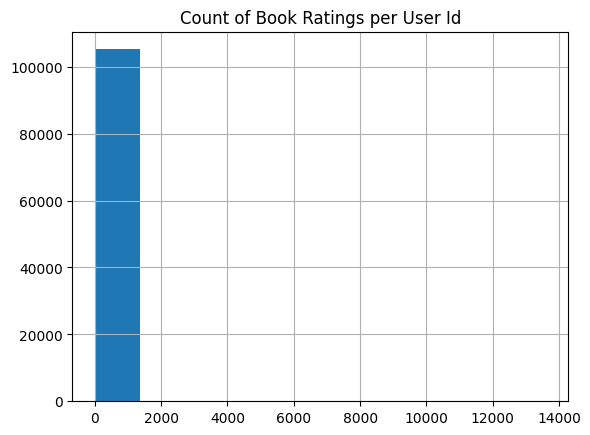

In [ ]:
# How many user ratings per Book ID do we have?

# Histogram
ratings_df[['User_ID','ISBN']].groupby(['User_ID']).count().hist()
plt.title("Count of Book Ratings per User Id")
plt.show()

In [ ]:
# Table
ratings_df[['User_ID','ISBN']].groupby(['ISBN']).count().describe()

,User_ID
count,340556.000000
mean,3.376185
std,12.436252
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2502.000000


<Axes: title={'center': 'Count of Book_Rating Score'}, xlabel='Book_Rating'>

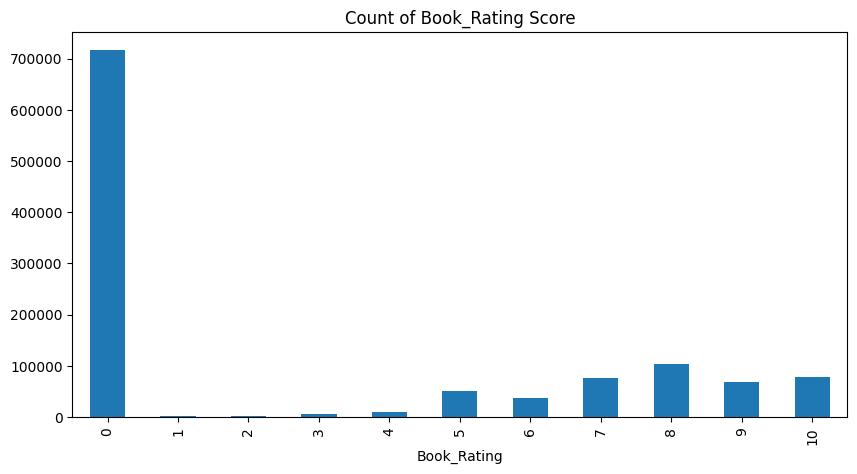

In [ ]:
# Rating distribution of our users

ratings_df['Book_Rating'].value_counts().sort_index().plot.bar(title="Count of Book_Rating Score",figsize=(10,5))

In [ ]:
# Remove ratings with 0
ratings_df = ratings_df[ratings_df['Book_Rating'] > 0]

## Data Preprocessing

In [ ]:
# Minimum number of rating that we will use
popularity_thres = 1

# Filter ratings_df
book_rating_cnt_df = ratings_df[['Book_Rating','ISBN']].groupby(['ISBN']).count()
popular_books_df = book_rating_cnt_df[book_rating_cnt_df['Book_Rating'] >= popularity_thres]

filtered_pop_books_df = ratings_df[ratings_df.ISBN.isin(popular_books_df.index.values)]
print('shape of original ratings data: ', ratings_df.shape)
print('shape of ratings data after dropping unpopular movies: ', filtered_pop_books_df.shape)

shape of original ratings data:  (433671, 3)
shape of ratings data after dropping unpopular movies:  (433671, 3)


In [ ]:
# filtering for active users
ratings_thres = 2

active_users_cnt_df = ratings_df[['User_ID','ISBN']].groupby(['User_ID']).count()
active_users_df = active_users_cnt_df[active_users_cnt_df['ISBN'] >= ratings_thres]

filtered_popular_active_df = filtered_pop_books_df[filtered_pop_books_df.index.isin(active_users_df.index.values)]
print('shape of original ratings data: ', filtered_pop_books_df.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', filtered_popular_active_df.shape)

shape of original ratings data:  (433671, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (12798, 3)


In [ ]:
# Inspect dataset
filtered_popular_active_df.head()

,User_ID,ISBN,Book_Rating
8,276744,038550120X,7
69,276780,8484330478,7
114,276812,8879839993,8
165,276832,0345446860,5
242,276853,8448034023,7


In [ ]:
# We merge our books and filtered rating data frames

merged_df = pd.merge(books_df, filtered_popular_active_df, on='ISBN')
merged_df.shape

(11009, 5)

In [ ]:
# Inspect dataset
merged_df.head()

,ISBN,Book_Title,Book_Author,User_ID,Book_Rating
0,0002005018,Clara Callan,Richard Bruce Wright,11676,8
1,0060973129,Decision in Normandy,Carlo D'Este,2954,8
2,0671870432,PLEADING GUILTY,Scott Turow,11676,8
3,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,8,5
4,0440234743,The Testament,John Grisham,3329,8


In [ ]:
# Now let's pivot the dataframe such that it will have ISBN as the index, and userId as columns
book_features_df=merged_df.pivot_table(index='ISBN', columns='User_ID', values='Book_Rating').fillna(0)
book_features_df.head()

User_ID,8,53,67,85,92,141,212,228,242,243,...,278637,278648,278663,278694,278732,278760,278832,278843,278849,278854
ISBN,,,,,,,,,,,,,,,,,,,,,
0001047213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0001047973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000104799X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002005018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0002165368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Transform matrix into a csr_matrix
book_features_df_matrix = csr_matrix(book_features_df.values)

## KNN Model

In [ ]:
# KNN Model
model_knn = NearestNeighbors(metric = 'cosine',  algorithm = 'brute')

# Fit KNN model
model_knn.fit(book_features_df_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# Let's try it out
fav_book = "Magic"
print('You have input book:', fav_book)

# find movies that "match" title
book_matches_df = merged_df[merged_df['Book_Title'].str.contains(fav_book)]
book_matches_df

You have input book: Magic


,ISBN,Book_Title,Book_Author,User_ID,Book_Rating
502,0425174484,"Expecting Adam: A True Story of Birth, Rebirth...",Martha Beck,22154,5
612,0064405052,The Magician's Nephew (Narnia),C. S. Lewis,36609,10
1466,8440682441,El Circulo Magico,Katherine Neville,2084,6
1485,0345317580,Magic Kingdom for Sale - Sold! (Magic Kingdom ...,Terry Brooks,2399,7
1486,0345317580,Magic Kingdom for Sale - Sold! (Magic Kingdom ...,Terry Brooks,22780,8
...,...,...,...,...,...
10166,0307760278,What's the Monster Making? (Magic Corner Books),Constance Allen,35859,10
10170,0590419919,Second-Hand Magic,Ruth Chew,56447,5
10587,1862040761,The Elements of Natural Magic (The elements of),Marian Green,64015,7
10706,0394858573,"Say the Magic Word, Please: Featuring Jim Hens...",Anna Ross,11676,9


In [ ]:
print("Let's start making recommendations!...")

if(book_matches_df is  None):
    print("No Matching books :(")
else:
    # Indicate the top recommendations we want to get (how many neighbors should we find?)
    top_recommendations = 10

    book_idx = book_matches_df.iloc[0]['ISBN'] # select the first book in the list, get the ISBN

    # get the dataframe index from the movieId
    book_idx = merged_df[merged_df['ISBN'] == book_idx].index[0]

    # model will return a list of distances and indices
    distances , indices = model_knn.kneighbors(book_features_df_matrix[book_idx],n_neighbors=top_recommendations+1)

    # transform the result into a list
    rec_book_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = [] #let's create an empty list

    # we will iterate thru the results and add them to the list
    for val in rec_book_indices:

        # we get the book id
        book_idx = merged_df.iloc[val[0]]['ISBN']
        # convert into an index, we will this use to get the movie title
        idx = merged_df[merged_df['ISBN'] == book_idx].index
        # take the movie title together with the computed "distance". This distance is how far the movies are from the 'target' movie
        recommend_frame.append({'Book_Title':merged_df.iloc[idx]['Book_Title'].values[0], 'Distance':val[1]})

    # place resulting list inside a dataframe
    df = pd.DataFrame(recommend_frame,index=range(1,top_recommendations+1))
    display(df.sort_values("Distance")) #sort by distance to get the top 10


Let's start making recommendations!...


,Book_Title,Distance
1,The Nanny Diaries: A Novel,0.0
2,The Most Beautiful Villages of England,0.0
3,Driving Force,0.0
4,Good in Bed,0.0
5,Among the Shadows,0.0
6,Einmal ist keinmal.,0.0
7,The Rich Man's Table,0.0
8,Bukan puteri lindungan bulan,0.0
9,Stand Your Ground: Devotions for Teens by Teens,0.0
10,Myth-Ion Improbable (Myth Books),0.0


## KNN Model Evaluation

In [ ]:
# Let's use surprise library to get a measure of our knn model's RMSE metric
# The Reader class is used to parse a file containing ratings.
# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(merged_df[['User_ID', 'ISBN', 'Book_Rating']], reader)

# We'll train a knn model in surprise using our same data set
knnbasic = KNNBasic()

# Run 5-fold cross-validation and print results.
knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.8909  1.7859  1.8577  1.8328  1.8844  1.8503  0.0383  
Fit time          0.20    0.21    0.20    0.22    0.26    0.22    0.02    
Test time         0.02    0.02    0.02    0.01    0.03    0.02    0.00    


{'test_rmse': array([1.89093445, 1.78586904, 1.85772396, 1.83276336, 1.88443085]),
 'fit_time': (0.19570207595825195,
  0.20530176162719727,
  0.20334982872009277,
  0.22069811820983887,
  0.26126813888549805),
 'test_time': (0.01897120475769043,
  0.017247438430786133,
  0.019335508346557617,
  0.014944314956665039,
  0.025371074676513672)}

## SVD Model

In [ ]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(merged_df[['User_ID', 'ISBN', 'Book_Rating']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
svd_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
svd_results

# Smaller RMSE means our model is able to give better recommendation

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.7745  1.7873  1.7454  1.7385  1.7294  1.7550  0.0221  
Fit time          0.32    0.35    0.31    0.35    0.34    0.34    0.02    
Test time         0.02    0.02    0.02    0.03    0.02    0.02    0.00    


{'test_rmse': array([1.77451716, 1.78733308, 1.74535057, 1.73854284, 1.72941912]),
 'fit_time': (0.3190271854400635,
  0.35446667671203613,
  0.3108196258544922,
  0.3525679111480713,
  0.34421277046203613),
 'test_time': (0.01823902130126953,
  0.017763376235961914,
  0.0161588191986084,
  0.02872014045715332,
  0.016649723052978516)}

In [ ]:
# User rated 5
uid = str("11676")

# Book: Clara Callan by Richard Bruce Wright
iid = str("0002005018")

#Get the prediction for the specific users and book.
print("Prediction for rating: ")
pred = algo.predict(uid, iid, r_ui=8, verbose=True)
pred

Prediction for rating: 
user: 11676      item: 0002005018 r_ui = 8.00   est = 7.62   {'was_impossible': False}


Prediction(uid='11676', iid='0002005018', r_ui=8, est=7.622921941198497, details={'was_impossible': False})

## Model Comparison (KNN vs SVD)

### RMSE

In [ ]:
metric_df = pd.DataFrame()
metric_df['knn'] = knn_results['test_rmse']
metric_df['svd'] = svd_results['test_rmse']

# Create DataFrames for mean and standard deviation with an index
tmp_dict1 = pd.DataFrame({'knn':[metric_df['knn'].mean()], 'svd':[metric_df['svd'].mean()]}, index=['Mean'])
tmp_dict2 = pd.DataFrame({'knn':[metric_df['knn'].std()], 'svd':[metric_df['svd'].std()]}, index=['Std'])

# Set the index for the original metric_df before concatenation
metric_df.index = [f'Fold {i+1}' for i in range(len(metric_df))]

metric_df = pd.concat([metric_df, tmp_dict1, tmp_dict2])
metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']

metric_df

,knn,svd
Fold 1,1.890934,1.774517
Fold 2,1.785869,1.787333
Fold 3,1.857724,1.745351
Fold 4,1.832763,1.738543
Fold 5,1.884431,1.729419
Mean,1.850344,1.755033
Std,0.042808,0.024722


## Top N Prediction and Hit Rate

In [ ]:
from collections import defaultdict

# accept list of predictions and n of top n
#this is like our scoring algorithm for reco engines

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = book id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():

        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
from surprise.model_selection import LeaveOneOut

# Let's rebuild our models
# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(1, 10))

# Define the rating scale and dataset for Surprise
data = Dataset.load_from_df(merged_df[['User_ID', 'ISBN', 'Book_Rating']], reader)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()
svd = SVD()

# fit using generated training set from data
knn.fit(LOOCVTrain)
svd.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)
svd_predictions = svd.test(LOOCVAntiTestSet)


Computing the msd similarity matrix...
Done computing similarity matrix.


In [ ]:
# Generate top 10 recommendations per user (books not in training set)
knn_top_n = get_top_n(knn_predictions, n=10)
svd_top_n = get_top_n(svd_predictions, n=10)

# Print the recommended books for each user
print("\nTop-N recommendations using KNN:")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("\nTop-N recommendations using SVD:")
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


Top-N recommendations using KNN:
11676 ['0553379534', '0312270828', '0299094944', '0553250426', '0553250531', '0451160533', '006447108X', '0425104338', '0061091944', '0140424385']
20916 ['0002005018', '0671870432', '0452264464', '042511774X', '0671004573', '0385337639', '3257233051', '3453212150', '0316602906', '0380717018']
62667 ['0002005018', '0671870432', '0452264464', '042511774X', '0671004573', '0385337639', '3257233051', '3453212150', '0316602906', '0380717018']
12863 ['0671004573', '0385337639', '3257233051', '3453212150', '0446610399', '0671027387', '0451523415', '0805062971', '0743457943', '0684835983']
49980 ['0671004573', '0385337639', '3257233051', '3453212150', '0446610399', '0671027387', '0451523415', '0805062971', '0743457943', '0684835983']
21031 ['0586209816', '0553250426', '0553250531', '0451160533', '006447108X', '0425104338', '0061091944', '0140424385', '0064471063', '0609610996']
25583 ['0586209816', '0070212570', '0446364800', '0399137769', '0553250426', '055325

In [ ]:
# Utility function to get the book title based on the ISBN
def get_title_from_id(idx):
    title_row = merged_df.loc[merged_df['ISBN'] == idx, 'Book_Title']
    if not title_row.empty:
        return title_row.values[0]
    else:
        return "Unknown Title"

In [ ]:
# Print the recommended books for each user
print("")
print("Top-N recommendations for KNN:")
for uid, user_ratings in knn_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])

print("")
print("Top-N recommendations for SVD:")
for uid, user_ratings in svd_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])


Top-N recommendations for KNN:
11676 ["Women's Bodies, Women's Wisdom: Creating Physical and Emotional Health and Healing", 'The Satanic Verses (Bestselling Backlist)', "Daily Life in Johnson's London", "The Clan of the Cave Bear (Earth's Children (Paperback))", 'The Valley of Horses', 'She Who Remembers', 'The Last Battle', "Stephen King's Danse Macabre", 'Stonehenge', 'The Canterbury Tales (Penguin Classics)']
20916 ['Clara Callan', 'PLEADING GUILTY', 'Beloved (Plume Contemporary Fiction)', 'Breathing Lessons', 'Before I Say Good-Bye', 'Crow Lake (Today Show Book Club #7)', 'Veronika Deschliesst Zu Sterben / Vernika Decides to Die', 'Die Cappuccino- Jahre. Aus dem Tagebuch des Adrian Mole.', 'The Big Bad Wolf: A Novel', 'Body of Evidence (Kay Scarpetta Mysteries (Paperback))']
62667 ['Clara Callan', 'PLEADING GUILTY', 'Beloved (Plume Contemporary Fiction)', 'Breathing Lessons', 'Before I Say Good-Bye', 'Crow Lake (Today Show Book Club #7)', 'Veronika Deschliesst Zu Sterben / Vernika

In [ ]:
# HIT RATE — used for Top-N recommendation systems
# Measures how often the "left-out" book (the one a user actually rated)
# appears in that user's Top-N predicted recommendations.

def hitrate(topNpredictions, leftoutpredictions):

    userHitRates = []  # store per-user hit rates

    for leftout in leftoutpredictions:
        uid = leftout[0]           # User_ID
        leftout_ISBN = leftout[1]  # The left-out book (ISBN)

        print("User:", uid)
        print("Actual book rated (left-out):", leftout_ISBN)

        # get list of Top-N predicted books for this user
        predicted_books_list = []
        for pred_ISBN, predRating in topNpredictions.get(uid, []):
            predicted_books_list.append(pred_ISBN)

        print("Predicted top books:", predicted_books_list)

        # compute hit rate for this user
        hits = len(set([leftout_ISBN]).intersection(predicted_books_list))
        total = len(predicted_books_list)
        userHitRate = hits / total if total > 0 else 0

        userHitRates.append({"User_ID": uid, "User_HitRate": userHitRate})

    return pd.DataFrame(userHitRates)


In [ ]:
# Let's append this to our metric dataframe
final_metric_df = metric_df  # assuming you already computed RMSE for each fold

# Rename the index for clarity
final_metric_df.index = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5', 'Mean', 'Std']

print("Metric Comparison (RMSE) - Book Recommendation Dataset")
display(final_metric_df)


Metric Comparison (RMSE) - Book Recommendation Dataset


,knn,svd
Fold 1,1.890934,1.774517
Fold 2,1.785869,1.787333
Fold 3,1.857724,1.745351
Fold 4,1.832763,1.738543
Fold 5,1.884431,1.729419
Mean,1.850344,1.755033
Std,0.042808,0.024722


In [ ]:
print("SVD Hit Rate Metrics (Book Recommendation Dataset)")
svd_hitrate_df = hitrate(svd_top_n, leftoutpredictions)
display(svd_hitrate_df)

Streaming output truncated to the last 5000 lines.
Actual book rated (left-out): 0684853779
Predicted top books: []
User: 23768
Actual book rated (left-out): 0688156983
Predicted top books: ['059035342X', '0312983867', '0439139597', '0553379534', '0156027321', '0380789019', '0553296981', '0670844527', '0811824829', '0446605239']
User: 55511
Actual book rated (left-out): 0316548189
Predicted top books: []
User: 25827
Actual book rated (left-out): 0060924837
Predicted top books: ['0312980140', '044021145X', '0446605239', '0553274295', '0670844527', '0380789019', '0440498058', '0446672211', '0439139597', '0449212602']
User: 28525
Actual book rated (left-out): 0440226198
Predicted top books: []
User: 23581
Actual book rated (left-out): 0312954468
Predicted top books: []
User: 27929
Actual book rated (left-out): 0679781277
Predicted top books: []
User: 55683
Actual book rated (left-out): 0684863871
Predicted top books: []
User: 37886
Actual book rated (left-out): 0553568779
Predicted top bo

,User_ID,User_HitRate
0,11676,0.0
1,2954,0.0
2,8,0.0
3,3329,0.0
4,12685,0.0
...,...,...
4366,278260,0.0
4367,278648,0.0
4368,278545,0.0
4369,278563,0.0


In [ ]:
print("\nKNN Hit Rate Metrics (Book Recommendation Dataset)")
knn_hitrate_df = hitrate(knn_top_n, leftoutpredictions)
display(knn_hitrate_df)


KNN Hit Rate Metrics (Book Recommendation Dataset)
User: 11676
Actual book rated (left-out): 0440224624
Predicted top books: ['0553379534', '0312270828', '0299094944', '0553250426', '0553250531', '0451160533', '006447108X', '0425104338', '0061091944', '0140424385']
User: 2954
Actual book rated (left-out): 0060973129
Predicted top books: []
User: 8
Actual book rated (left-out): 074322678X
Predicted top books: []
User: 3329
Actual book rated (left-out): 0440234743
Predicted top books: []
User: 12685
Actual book rated (left-out): 0440234743
Predicted top books: []
User: 20916
Actual book rated (left-out): 0440234743
Predicted top books: ['0002005018', '0671870432', '0452264464', '042511774X', '0671004573', '0385337639', '3257233051', '3453212150', '0316602906', '0380717018']
User: 62667
Actual book rated (left-out): 0440234743
Predicted top books: ['0002005018', '0671870432', '0452264464', '042511774X', '0671004573', '0385337639', '3257233051', '3453212150', '0316602906', '0380717018']
U

,User_ID,User_HitRate
0,11676,0.0
1,2954,0.0
2,8,0.0
3,3329,0.0
4,12685,0.0
...,...,...
4366,278260,0.0
4367,278648,0.0
4368,278545,0.0
4369,278563,0.0


## Conclusion

The following are the conclusion:

1. Based on RMSE, there seems to be no significant difference between the KNN and SVD models. However, SVD consistently achieved slightly lower RMSE values across all folds, indicating better predictive accuracy overall.
2. The lower standard deviation of SVD makes it reasonable to suggest that SVD performs more stable across different data splits compared to KNN.
3. Many users had no predicted top books in the top-N recommendations, which highlights data sparsity
4. Hit Rate metrics show that the models were able to recommend books for some users, but then again, recommendation coverage is limited due to sparse user–item interactions.

## Recommendations

The following are the recommendations:

1. Further refine dataset, while every entry is unique as we have removed duplicate records, creating a pivot table using Book-Title and Book-Author reveals there are some books written by the same author appearing multiple times, this is due to multiple Year-Of-Publication or Publishier or both. This multiple entries may affect the performance of the model.
2. Combining content-based filtering with collaborative filtering and collecting more ratings per user will improve top-N recommendations.